# 4e. Generate predictions using a customisable hospital hierarchy. 

In previous notebooks I have shown the prediction of demand by service, using a hard-coded list of specialties (medical, surgical, haem/onc and pediatric).

In the real UCLH application, our users are interested in multiple levels of prediction. For example, within the medical division, the Medical Director might want high level information about pressure on the division as a whole, while a ward manager might want to know specifically about the pressures of their clinical area. 

To support predection at a fine-grained level at UCLH, where there are approximately 50 reporting units and 500+ subspecialties, a hard-coded list is unsuitable. Instead, we want the list of specialties to be dynamic, and we want to be able to map these to the hospital's standard reporting groupings.

This notebooks shows code to set up hospital hierarchy to achieve this.

A typical workflow is:

1. Create or load a hierarchy structure

2. Populate the hierarchy with organisational data

3. Prepare prediction data

4. Generate predictions by running the prediction routine

5. Access results at any level


## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## 1. Create the hierarchy

Here I create a very simple hierarchy comprising only two levels. In the public dataset we only have four specialites available, so we'll pretend that these fall within three hospital divisions: medical, surgical and specialist. 

The first step is to create an entry in config.yaml specifying the names of each level and their relationship in the hierarchy. These names could be anything (eg 'specialty' could be 'clinical area' or 'firm'). It should look something like this: 

```yaml
# Hierarchy configuration
# Defines the organizational hierarchy structure
levels:
  - entity_type: specialty
    parent_type: division
    level_order: 0
  - entity_type: division
    parent_type: null
    level_order: 1
  - entity_type: hospital
    parent_type: null
    level_order: 2
  ```

In [3]:
from patientflow.predict.hierarchy.structure import Hierarchy, populate_hierarchy_from_dataframe
import pandas as pd

# Read the yaml file to populate a hierarchy object
hierarchy = Hierarchy.from_yaml(project_root / "config.yaml")

# The hierarchy object has a `levels` attribute that shows the names of each level 
# and their relationship in the hierarchy.
print(hierarchy.levels)  

{EntityType('specialty'): HierarchyLevel(entity_type=EntityType('specialty'), parent_type=EntityType('division'), level_order=0), EntityType('division'): HierarchyLevel(entity_type=EntityType('division'), parent_type=EntityType('hospital'), level_order=1), EntityType('hospital'): HierarchyLevel(entity_type=EntityType('hospital'), parent_type=None, level_order=2)}


## 2. Populate the hierarchy with organisational data

Thus far, we only know the names of the levels (specialty, division), but not their contents. We can specify these in using a dataframe. The `column_mapping`parameter maps the column names in the dataframe to those specified in the hierarchy object. 

In [4]:
hierarchy_df = pd.DataFrame({
    'specialty_names': ['medical', 'surgical', 'haem/onc', 'paediatric'],
    'division_names': ['Medical Division', 'Surgical Division', 'Medical Division', 'Specialist Hospitals Division'],
})

column_mapping = {
    'specialty_names': 'specialty', # the column name in the dataframe that contains the specialty names
    'division_names': 'division', # the column name in the dataframe that contains the division names
}
populate_hierarchy_from_dataframe(
    hierarchy, hierarchy_df, column_mapping, top_level_id="Hospital"
)

print(hierarchy)

Hierarchy:
  specialty: 4
  division: 3
  hospital: 1


### Important note when creating hierarchies. 

The hierarchy must form a tree structure where each child entity can only have one parent. If the same child appears with different parents in different rows, the last relationship processed will overwrite previous ones, silently creating an invalid hierarchy. 

For example, this would be INVALID: 

Row 1: subspecialty='Cardiology', reporting_unit='Unit X', division='Division A' followed by Row 2: subspecialty='Cardiology', reporting_unit='Unit X', division='Division B'. 

This would result in 'Unit X' being assigned only to 'Division B' (the last one processed), overwriting the relationship to 'Division A', which violates the tree structure requirement and should be avoided. Note: Only entity types with a column_mapping entry will have entities created from the DataFrame, and the top_level_id ensures a single top-level entity exists (created if not in DataFrame, consolidated if present)


## Prepare the prediction data

First, this will require loading data, and training the models, as has been done in previous notebooks. 

### Load data and prepare the models. 

I'm going to use real patient data from UCLH to demonstrate the implementation. I will follow the same method as in [notebook 4b](4b_Predict_emergency_demand.ipynb). Skip to the next cell. 

In [5]:
from patientflow.load import set_file_paths
import pandas as pd
from datetime import timedelta
from patientflow.load import load_data
from patientflow.load import load_config_file
from patientflow.prepare import create_temporal_splits
from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor
from patientflow.predictors.subgroup_predictor import MultiSubgroupPredictor
from patientflow.predictors.incoming_admission_predictors import ParametricIncomingAdmissionPredictor


# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml', verbose=False)


# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)

# set the training, validation and test sets
params = load_config_file(config_path)
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]

# create temporal splits
train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, _ = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

# Train ED admissions model
grid = {"n_estimators": [30], "subsample": [0.7], "colsample_bytree": [0.7]} # simple grid for expediency

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

admissions_models = {}
model_name = 'admissions'

for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

# Train specialty model
def create_subgroup_functions_from_age_group():
    """Create subgroup functions that work with age_group categorical variable."""
    
    def is_paediatric(row):
        return row.get("age_group") == "0-17"
    
    def is_adult(row):
        # All non-paediatric patients are adults
        return row.get("age_group") != "0-17"
    
    return {
        "paediatric": is_paediatric,
        "adult": is_adult,
    }

subgroup_functions = create_subgroup_functions_from_age_group()

spec_model = MultiSubgroupPredictor(
    subgroup_functions=subgroup_functions,
    base_predictor_class=SequenceToOutcomePredictor,
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    min_samples=50,  # Minimum samples required per subgroup
)
spec_model = spec_model.fit(train_visits_df)

# Train yet-to-arrive model
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = timedelta(minutes=params["prediction_window"])
yta_time_interval = timedelta(minutes=params["yta_time_interval"])

specialty_filters = filters={
    'medical': {'specialty': 'medical'},
    'surgical': {'specialty': 'surgical'},
    'haem/onc': {'specialty': 'haem/onc'},
    'paediatric': {'specialty': 'paediatric'}
    }

yta_model_by_spec =  ParametricIncomingAdmissionPredictor(filters = specialty_filters, verbose=False)

num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]
Training model for (22, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (12, 0)
Training model for (9, 30)


### Prepare an object containing the inputs to the prediction pipeline

We now have models trained that we can use to create predicted probability distributions. To illustrate, I'll pick a random prediction date and time from the test set. 

In [6]:
from patientflow.viz.utils import format_prediction_time
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict

# Set seed
import numpy as np
np.random.seed(42)

# Randomly pick a prediction moment to do inference on
random_row = test_visits_df.sample(n=1)
random_prediction_time = random_row.prediction_time.values[0]
random_prediction_date = random_row.snapshot_date.values[0]

prediction_snapshots = ed_visits[(ed_visits.prediction_time == random_prediction_time) & \
            (ed_visits.snapshot_date == random_prediction_date)]

print(f'Number of adult patients in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group != "0-17"])}')

print(f'Number of patients under the age of 18 in the ED at {format_prediction_time(random_prediction_time)} on {random_prediction_date}:',
      f'{len(prediction_snapshots[prediction_snapshots.age_group == "0-17"])}')



Number of adult patients in the ED at 22:00 on 2031-10-09: 69
Number of patients under the age of 18 in the ED at 22:00 on 2031-10-09: 10


Using the function below, I prepare prediction inputs, ready for the hierarchy orchestrator. The `build_service_data` function is introduced with more detail in notebook 4b. 

In [7]:
from patientflow.predict.service import build_service_data

# select the relevant ED admissions model based on the prediction time
admission_model = admissions_models[get_model_key(model_name, random_prediction_time)]

# convert elapsed_los to timedelta to ensure correct calculation of probability of admission within prediction window
prediction_snapshots_processed = prediction_snapshots.copy(deep=True)
prediction_snapshots_processed['elapsed_los'] = pd.to_timedelta(prediction_snapshots_processed['elapsed_los'], unit='s')

# generate the prediction inputs
prediction_inputs = build_service_data(
    models=(admission_model, None, spec_model, yta_model_by_spec, None, None, None),
    prediction_time=random_prediction_time,
    ed_snapshots=prediction_snapshots_processed,
    inpatient_snapshots=None,  
    specialties=specialty_filters.keys(),
    prediction_window=timedelta(hours=8),
    x1=x1, y1=y1, x2=x2, y2=y2
)


The returned object is a dictionary, keyed by the various entities that were passed in the specialties parameter. This should be the lowest level of granularity for which predictions are desired. Below is a summary of what the object contains for one of our specialties. 

In [8]:
prediction_inputs['medical']

ServicePredictionInputs(service='medical')
  INFLOWS:
    Admissions from current ED               PMF[3:13]: [0.023, 0.051, 0.092, 0.137, 0.168, 0.171, 0.144, 0.100, 0.058, 0.027] (E=7.6 of 79 patients in ED)
    ED yet-to-arrive admissions              λ = 2.090
    Non-ED emergency admissions              λ = 0.000
    Elective admissions                      λ = 0.000
    Elective transfers from other services   PMF[0:1]: [1.000] (E=0.0)
    Emergency transfers from other services  PMF[0:1]: [1.000] (E=0.0)
  OUTFLOWS:
    Emergency inpatient departures           PMF[0:1]: [1.000] (E=0.0 of 0 emergency patients in service)
    Elective inpatient departures            PMF[0:1]: [1.000] (E=0.0 of 0 elective patients in service)

I can now use the prediction inputs to generate predictions for the lowest level. 

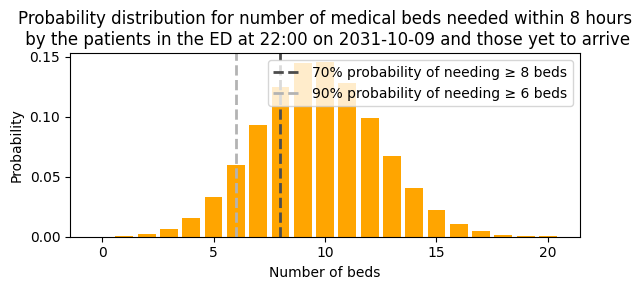

In [9]:
from patientflow.predict.demand import DemandPredictor, FlowSelection 
predictor = DemandPredictor(k_sigma=8.0)  # Controls distribution width caps
from patientflow.viz.probability_distribution import plot_prob_dist 

title = (
    f'Probability distribution for number of medical beds needed within {int(prediction_window.total_seconds()/3600)} hours\n'
    f' by the patients in the ED at {format_prediction_time(random_prediction_time)} '
    f'on {random_prediction_date} and those yet to arrive'
)

bundle = predictor.predict_service(
    inputs=prediction_inputs['medical'],
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=True, 
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  # No departures
        # cohort="emergency" # No need to specify this as we have not included elective patients
    ))

plot_prob_dist(bundle.arrivals.probabilities, title, 
    include_titles=True, truncate_at_beds=20,
    probability_levels=[0.7,0.9],
    show_probability_thresholds=True, bar_colour='orange')

## 4. Generate predictions using the hierarchy

Using the hierarchy, we can generate predictions at higher levels, like the Medical Division or the Hospital as a whole

In [10]:
from patientflow.predict.hierarchy import HierarchicalPredictor
from patientflow.predict.demand import DemandPredictor, FlowSelection

# Instantiate using the existing hierarchy
hierarchical_predictor = HierarchicalPredictor(
    hierarchy, 
    DemandPredictor(k_sigma=8.0))

# Run predictions, specifying flow selection
results = hierarchical_predictor.predict_all_levels(
    prediction_inputs,
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=True, 
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  # No departures
        cohort="emergency"
    ))

The returned object is a dictionary with keys for each entity in the hierarchy, at any level.

In [11]:
print(f"Hierarchical predictor returned {len(results)} entities:")
for key in results.keys():
    print(f" - {key}")
print(f"Value type for each entity: {type(results['medical']).__name__}")
print("\nThe predicted demand for an entity can be neatly viewed by printing it, producing the following output:\n")
print(results['medical'])


Hierarchical predictor returned 8 entities:
 - haem/onc
 - medical
 - Medical Division
 - surgical
 - Surgical Division
 - paediatric
 - Specialist Hospitals Division
 - Hospital
Value type for each entity: PredictionBundle

The predicted demand for an entity can be neatly viewed by printing it, producing the following output:

PredictionBundle(service: medical)
  Arrivals:    PMF[5:15]: [0.033, 0.060, 0.093, 0.125, 0.145, 0.146, 0.128, 0.099, 0.067, 0.041] (E=9.7)
  Departures:  PMF[0:1]: [1.000] (E=0.0)
  Net flow:    PMF[5:15]: [0.033, 0.060, 0.093, 0.125, 0.145, 0.146, 0.128, 0.099, 0.067, 0.041] (E=9.7)
  Flows:       selection cohort=emergency inflows(ed_current=True, ed_yta=True, non_ed_yta=False, elective_yta=False, transfers_in=False) outflows(departures=False)


## 5. Access results at any level

Below we can see the results for different leves of the hierarchy

In [12]:
print('Results for medical specialty')
print(results['medical'])
print('\nResults for Medicine Division')
print(results['Medical Division'])
print('\nResults for Hospital')
print(results['Hospital'])

Results for medical specialty
PredictionBundle(service: medical)
  Arrivals:    PMF[5:15]: [0.033, 0.060, 0.093, 0.125, 0.145, 0.146, 0.128, 0.099, 0.067, 0.041] (E=9.7)
  Departures:  PMF[0:1]: [1.000] (E=0.0)
  Net flow:    PMF[5:15]: [0.033, 0.060, 0.093, 0.125, 0.145, 0.146, 0.128, 0.099, 0.067, 0.041] (E=9.7)
  Flows:       selection cohort=emergency inflows(ed_current=True, ed_yta=True, non_ed_yta=False, elective_yta=False, transfers_in=False) outflows(departures=False)

Results for Medicine Division
PredictionBundle(division: Medical Division)
  Arrivals:    PMF[7:17]: [0.026, 0.047, 0.073, 0.100, 0.122, 0.133, 0.129, 0.112, 0.088, 0.062] (E=12.4)
  Departures:  PMF[0:1]: [1.000] (E=0.0)
  Net flow:    PMF[7:17]: [0.026, 0.047, 0.073, 0.100, 0.122, 0.133, 0.129, 0.112, 0.088, 0.062] (E=12.4)
  Flows:       selection cohort=emergency inflows(ed_current=True, ed_yta=True, non_ed_yta=False, elective_yta=False, transfers_in=False) outflows(departures=False)

Results for Hospital
Pre

Components of the arrivals flow can be examined. 

In [13]:
print(f"{results['Medical Division'].arrivals.expectation:.1f} patients are expected to need beds in the Medical Division.")
print(f"25th, 50th and 75th percentiles for probability distribution are: {results['Medical Division'].arrivals.percentiles}")



12.4 patients are expected to need beds in the Medical Division.
25th, 50th and 75th percentiles for probability distribution are: {25: 10, 50: 12, 75: 14}


We can get the minimum number of beds needed with a given probability, as shown in notebook 4b.

In [14]:
prob = 0.9
min_beds = results['Medical Division'].arrivals.min_beds_with_probability(prob)
print(
    f"There is a {prob:.0%} probability of needing at least "
    f"{min_beds} beds for arrivals to the Medical Division "
    f"in the {int(prediction_inputs['medical'].prediction_window.total_seconds() / 3600)} hours after the prediction moment"
)

There is a 90% probability of needing at least 9 beds for arrivals to the Medical Division in the 8 hours after the prediction moment


In [15]:
hierarchical_predictor

In [16]:
from patientflow.predict.hierarchy import EntityType

divisions = hierarchical_predictor.hierarchy.get_entities_by_type(EntityType("division"))
print(f'Get a list of entities of a certain type')
print(f'hierarchical_predictor.hierarchy.get_entities_by_type(EntityType("division") returns: {divisions}')

print(f'\nNote that excluding EntityType will return nothing')
print(f'hierarchical_predictor.hierarchy.get_entities_by_type("division") returns: {hierarchical_predictor.hierarchy.get_entities_by_type("division")}')

print(f'\nIf you know the entity ID of a parent, you can get its children like this:')
print(f"hierarchical_predictor.hierarchy.get_children('Hospital') returns: {hierarchical_predictor.hierarchy.get_children('Hospital')}")
print(f"hierarchical_predictor.hierarchy.get_children('Medical Division') returns: {hierarchical_predictor.hierarchy.get_children('Medical Division')}")

Get a list of entities of a certain type
hierarchical_predictor.hierarchy.get_entities_by_type(EntityType("division") returns: ['Medical Division', 'Surgical Division', 'Specialist Hospitals Division']

Note that excluding EntityType will return nothing
hierarchical_predictor.hierarchy.get_entities_by_type("division") returns: []

If you know the entity ID of a parent, you can get its children like this:
hierarchical_predictor.hierarchy.get_children('Hospital') returns: ['Medical Division', 'Surgical Division', 'Specialist Hospitals Division']
hierarchical_predictor.hierarchy.get_children('Medical Division') returns: ['haem/onc', 'medical']


### A useful shortcut 

We can skip manually creating and populating the Hierarchy object by using the `create_hierarchical_predictor()` function which does the following:
- Loading/creating the hierarchy structure (default or from config)
- Populating it with a DataFrame
- Initializing the DemandPredictor engine

In [17]:
from patientflow.predict.hierarchy import create_hierarchical_predictor
from patientflow.predict.demand import FlowSelection

hierarchy_df = pd.DataFrame({
    'specialty_names': ['medical', 'surgical', 'haem/onc', 'paediatric'],
    'division_names': ['Medical Division', 'Surgical Division', 'Medical Division', 'Specialist Hospitals Division'],
})

column_mapping = {
    'specialty_names': 'specialty', # the column name in the dataframe that contains the specialty names
    'division_names': 'division', # the column name in the dataframe that contains the division names
}

shortcut_predictor = create_hierarchical_predictor(
    config_path=str(project_root / "config.yaml"),  
    hierarchy_df=hierarchy_df,
    column_mapping=column_mapping,
    top_level_id="Hospital",
    k_sigma=8.0
)
# Run predictions just as before
shortcut_results = shortcut_predictor.predict_all_levels(
    prediction_inputs, 
    flow_selection=FlowSelection.custom(
        include_ed_current=True,
        include_ed_yta=True, 
        include_non_ed_yta=False,
        include_elective_yta=False,
        include_transfers_in=False,
        include_departures=False,  # No departures
        cohort="emergency"
    ))
print(f"Shortcut method produced predictions for {len(shortcut_results)} entities.")
print(f"{results['Medical Division'].arrivals.expectation:.1f} patients are expected to need beds in the Medical Division.")


Shortcut method produced predictions for 8 entities.
12.4 patients are expected to need beds in the Medical Division.


## Summary

In this notebook, we advanced from service-level predictions to a **hierarchical prediction system**. This allows you to view demand at any organisational level—from individual wards to entire divisions or the whole hospital—ensuring consistency across all views.

I demonstrated a flexible, data-driven approach where the organisational structure is defined dynamically rather than hard-coded. I showed how to create this hierarchy, populate it with real organisational data, and generate predictions at any level of the hierarchy.

This makes the use of `patientflow` configurable to any reporting hierarchy that your hospital wishes to use for predictions. 